# Notebook Introduction

**TL;DR**: After analysing the metrics the most successful mode came from using a Random Forest Classifier and resamping the dataset with SMOTE.

<ins>**Contents**</ins>:
* [Library Imports](#Library-Imports)
* [Data Import](#Data-Import)
* [Analysis of Results](#Analysis-of-Results)
    * [F1 Scores](#F1-Scores)
    * [Recall Scores](#Recall-Scores)
    * [Confusion Matrix](#Confusion-Matrix)
    * [Precision-Recall Curve](#Precision-Recall-Curve)

# Library Imports

In [1]:
import pandas as pd

In [2]:
# Import functions.py file
import sys
sys.path.append('../')

from functions.functions import *

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Import

In [57]:
# F1 Scores Summary Table
f1_scores_df = pd.read_csv('../data/processed/f1_scores', index_col=0)

# Recall Scores Summary Table
recall_scores_df = pd.read_csv('../data/processed/recall_scores', index_col=0)

# Predictions Table
y_preds = pd.read_csv('../data/processed/predictions', index_col=0)

# Prediction Probability Table
y_preds_proba = pd.read_pickle('../data/processed/predictions_probabilities.pkl')
# y_preds_proba = pd.read_csv('../data/processed/predictions_probabilities', index_col=0, dtype=float)

# Y_test
y_test = pd.read_csv('../data/processed/y_test.gz', compression='gzip').values.ravel()

# Analysis of Results

## F1 Scores

* Considers both Precision and Recall.  Can be interpreted as a weighted average of the two (harmonic mean)

\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}

In [4]:
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.117377,0.111208,0.121871,0.104411
Random Forest,0.885714,0.879725,0.222594,0.822430
XGBoost,0.865248,0.861953,0.117026,0.651399


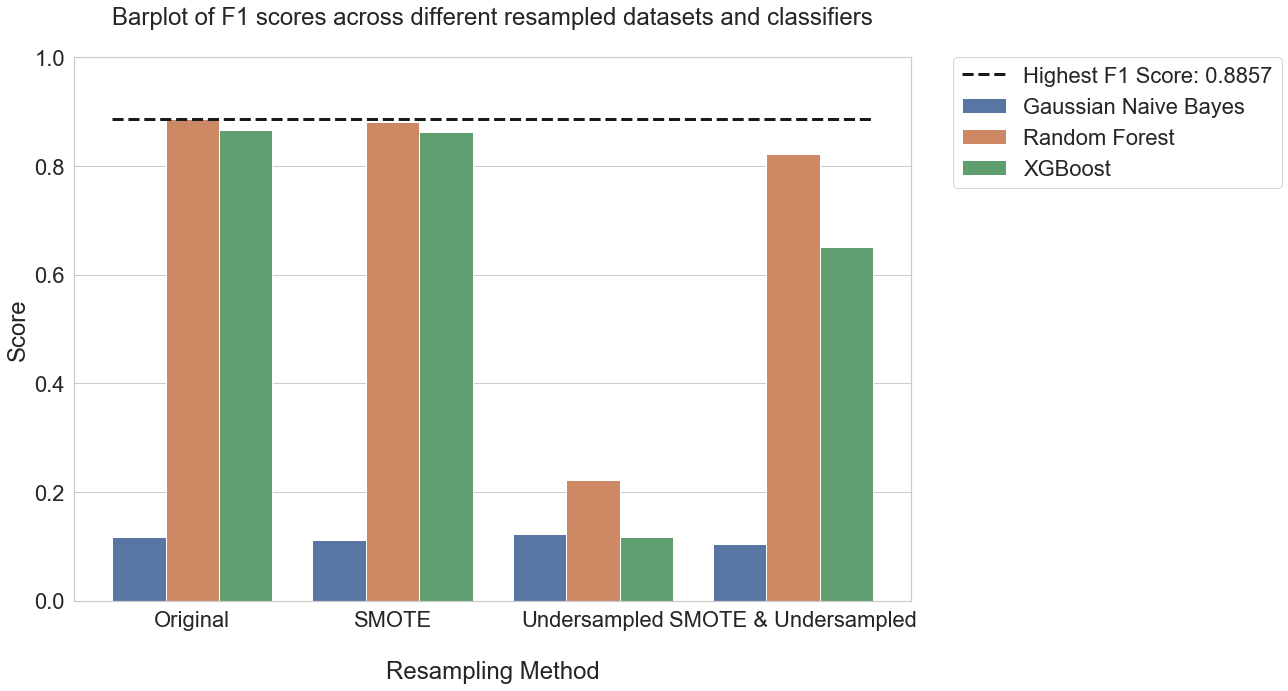

In [5]:
scores_bar_plot(reshape_scores_df(f1_scores_df), 'F1')

In [6]:
max_f1 = combination_for_best_score(f1_scores_df)

The highest score was 0.8857
This was achieved by resampling with Original and using the Random Forest classifier


* With such close performances it is worth investigating the performances with other metrics

## Recall Scores

* Out of all the actual frauds, what proportion did our model detect?

\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

In [7]:
recall_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.864865,0.864865,0.871622,0.871622
Random Forest,0.837838,0.864865,0.898649,0.891892
XGBoost,0.824324,0.864865,0.898649,0.864865


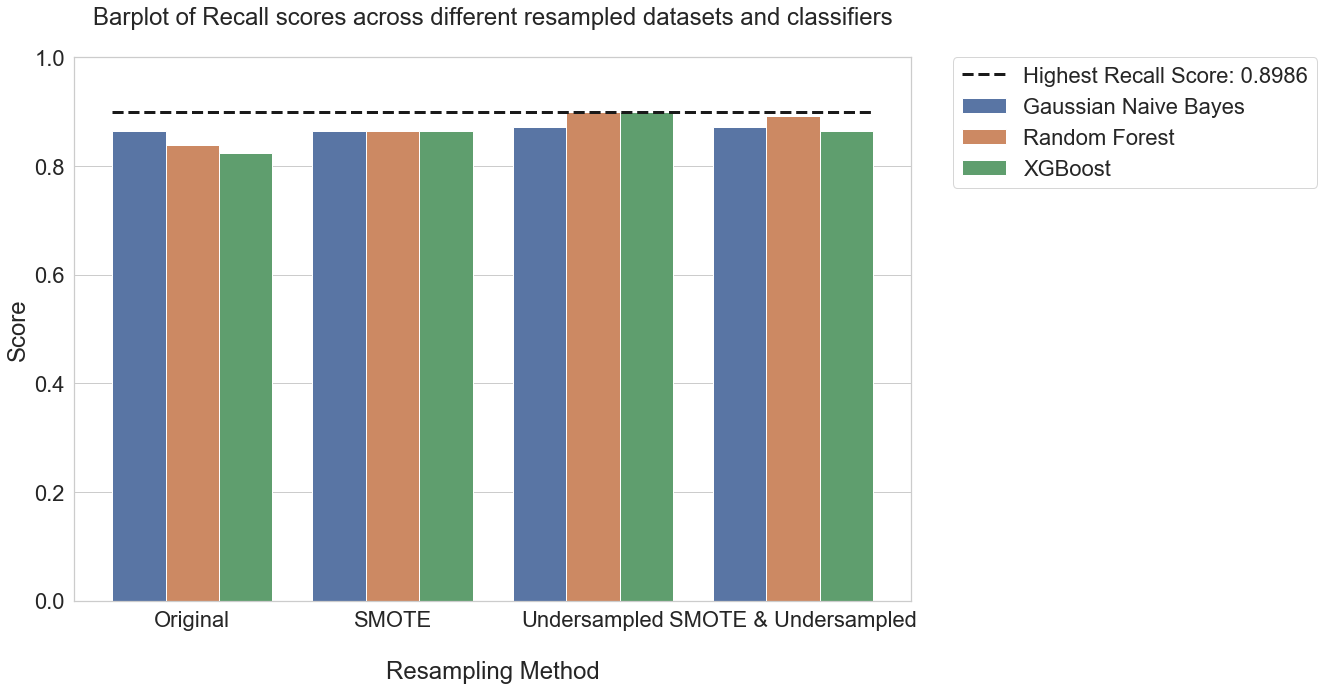

In [8]:
scores_bar_plot(reshape_scores_df(recall_scores_df), 'Recall')

In [9]:
max_recall = combination_for_best_score(recall_scores_df)

The highest score was 0.8986
This was achieved by resampling with Undersampled and using the Random Forest classifier


* Although the highest Recall scores came from the Undersampled training data, this data performed horribly in the F1 scores.  
* Once again the Original training data and the training data resampled with SMOTE have performed very similarly.  Further comparison is needed to choose a best combination.
* There appears to be many duplicated Recall Scores. 
    * An explanation could be that as there are only 148 fraud cases in the test data
    * It is quite likely that the model duplicates a recall calculation (i.e. finds TP=120 and FN=20 on more than one occasion)

## Confusion Matrix

* By analysing a confusion matrix of the two best performing models, we can look in particular at the False Negatives (i.e. the frauds that went undetected)

Confusion Matrix: 
TN: 85287 FP: 8 FN: 24 TP: 124


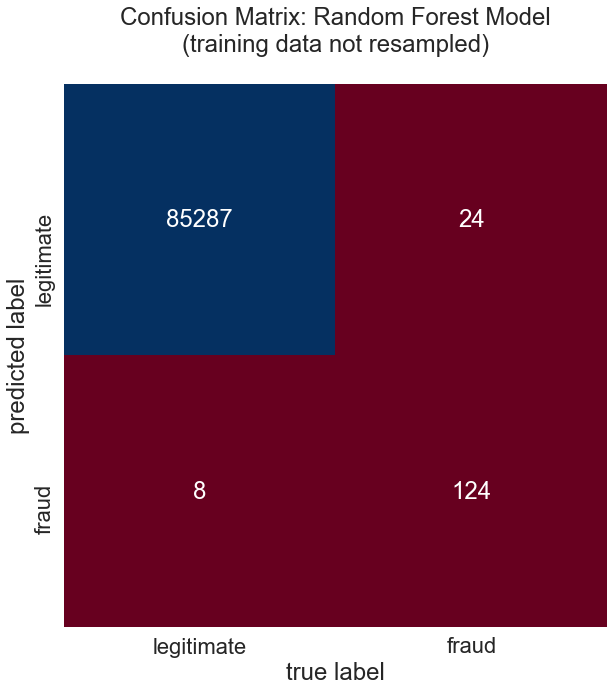

In [10]:
custom_confusion_matrix(y_test, y_preds['y_pred_rf_original'], 'Random Forest', 'not resampled')

Confusion Matrix: 
TN: 85280 FP: 15 FN: 20 TP: 128


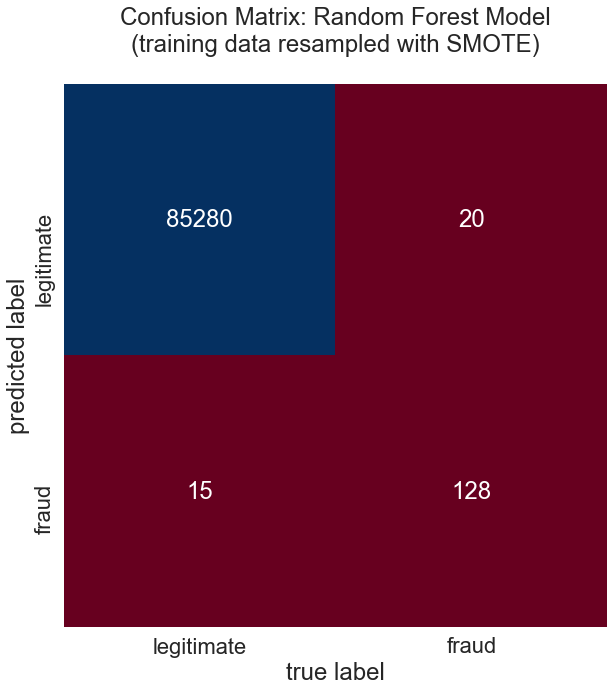

In [11]:
custom_confusion_matrix(y_test, y_preds['y_pred_rf_smote'], 'Random Forest', 'resampled with SMOTE', save_fig=True)

* Although the SMOTE model had higher False Positives, it had 4 fewer False Negatives, representing a 17% drop.

## Precision-Recall Curve

<details><summary><strong>PR Curve information</strong></summary>
    <br>

* The ROC (Receiver Operating Characteristic) curve is often used to assess machine learning models.  In this project however, the **ROC curve is not useful**.
    * It does not measure well for imbalanced data.
    * ROC curve does not measure the effects of negatives (as it uses the True Positive Rate) 
    * The AUC (Area Under the Curve) helps with assessing overall performance of the model but treats both classes equally.  
* We instead **must look at the PR (Precision-Recall) curve** to visualize how well our models have captured True Positives.  
    * The PR curve shows us how the model minimizes False Positives and False Negatives (very important for fraud detection)
    * With the highly imbalanced data, the AUC of the PR curve is also more sensitive than the ROC curve. This makes it easier to interpret
* The PR curve includes a "no-skill" baseline.
    * This is determined by the ratio of positives and negatives or P / (P + N)
* A perfect skil model will have a point at (1,1).
* The F1 Score measures the model skill for a specific probability threshold.
* The Area Under the Curve (AUC) summarizes the integral of the PR curve. i.e. the skill of the model across thresholds.
* Both F1 Score and AUC are useful measures for binary classification problems which have an imbalance in the dataset.
    </details>


Random Forest with no resampling: F1: 0.8857	AUC: 0.8742


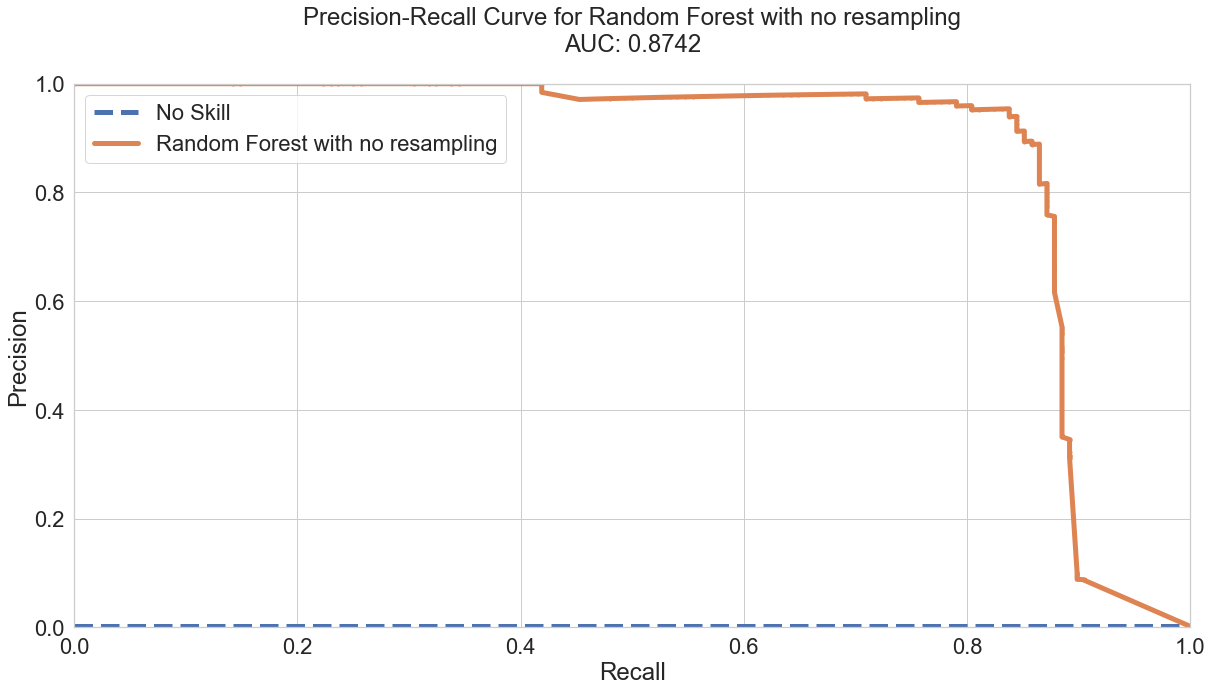

In [122]:
# Keep the probabilities for the fraud outcome only
proba_list = []
for x in range(len(y_preds_proba['y_pred_proba_rf_original'])):
    proba_list.append(y_preds_proba['y_pred_proba_rf_original'][x][1])

# Plot PR Curve for RF with Original Dataset
plot_pr_curve(y_test, y_preds['y_pred_rf_original'], proba_list, 'Random Forest with no resampling')

Random Forest with SMOTE: F1: 0.8797	AUC: 0.8818


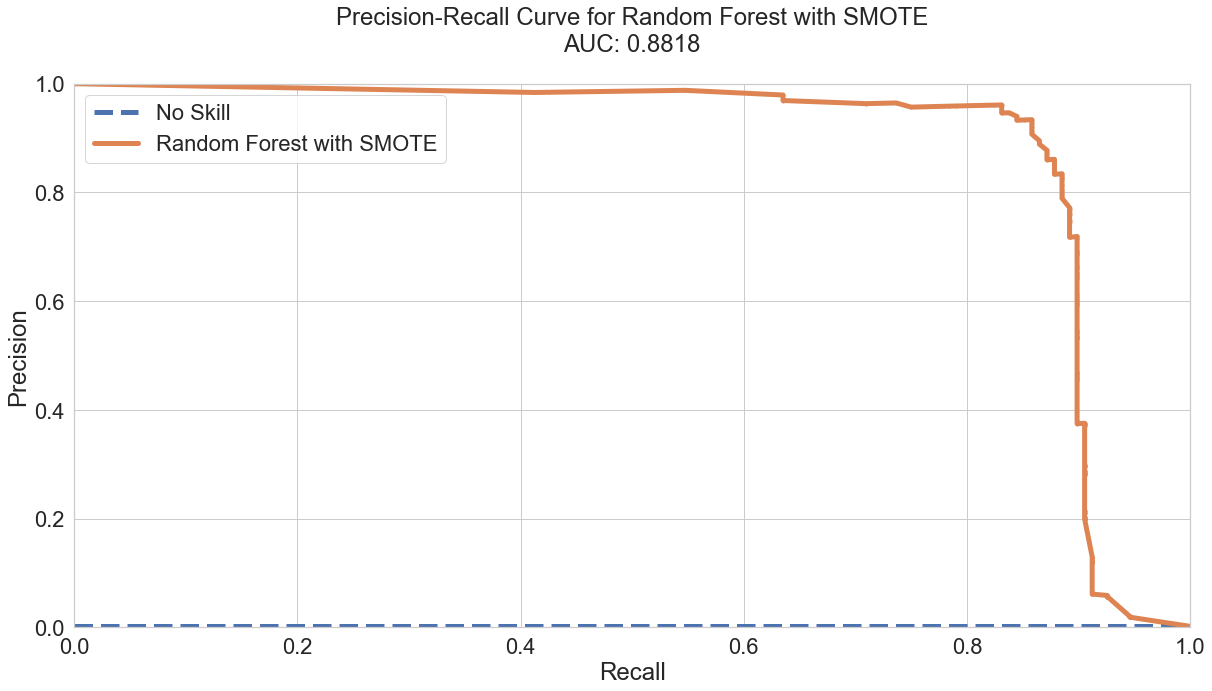

In [124]:
# Keep the probabilities for the fraud outcome only
proba_list = []
for x in range(len(y_preds_proba['y_pred_proba_rf_smote'])):
    proba_list.append(y_preds_proba['y_pred_proba_rf_smote'][x][1])

# Plot PR Curve for RF with SMOTE    
plot_pr_curve(y_test, y_preds['y_pred_rf_smote'], proba_list, 'Random Forest with SMOTE')

* The AUC for the SMOTE dataset is higher than that for the orginal dataset, which means the model is more effective across thresholds.
* Our most effective model came from using a Random Forest Classifier and resamping the dataset with SMOTE.